# Exploring results from different models

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pymongo
import json
import datetime
import pickle
import functions as fn
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import io
from sqlalchemy import create_engine

In [2]:
# Retrieve information to connect to the database
keys = fn.get_keys("/Users/jjherranzsarrion/.secret/local_info.json")
username = keys['username']
password = keys['password']

In [3]:
# Select your time ranges and add them in variables
train_window_end = '2018-08-05 23:59:59'
test_window_start = '2018-08-06 00:00:00'
test_window_end = '2018-08-07 23:59:59'
previous_day_start = '2018-08-05 00:00:00'

# Flirt with having more features

In [4]:
cursor = fn.extracting_cursor(username, password)

In [ ]:
status_df.head(10)

In [ ]:
q = f"""SELECT *
            FROM payments
            WHERE actor_id = '1000140982714368204';"""
cursor.execute(q)
payments_df = pd.DataFrame(cursor.fetchall())
payments_df.columns = [x[0] for x in cursor.description]

In [ ]:
payments_df

In [5]:
user_statistics = fn.get_aggregated_user_statistics(username, password, previous_day_start, train_window_end)

/Users/jjherranzsarrion/Documents/Data Science/FlatIron School/capstone/payments/venmo/functions.py:580: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  trans_made.fillna(0, inplace=True)
/Users/jjherranzsarrion/Documents/Data Science/FlatIron School/capstone/payments/venmo/functions.py:609: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  trans_rec.fillna(0, inplace=True)
/Users/jjherranzsarrion/Documents/Data Science/FlatIron School/capstone/payments/venmo/functions.py:623: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  trans.fillna(0, inplace=True)


In [ ]:
user_statistics.head()

In [ ]:
user_statistics.info()

In [6]:
tran_or_not_df = fn.extract_target(username, password, test_window_start, test_window_end)

In [7]:
complete_table = pd.merge(user_statistics, tran_or_not_df, 'outer', on='user_id')
complete_table.fillna(0, inplace=True)

In [8]:
X = complete_table.drop(['user_id', 'n_trans_made_in_measured_period'], axis=1)
y = complete_table['n_trans_made_in_measured_period']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [9]:
model = LogisticRegression(fit_intercept = False, C = 1e12, solver='liblinear')
model.fit(X_train_sc, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
model.coef_

array([[-0.01268416,  0.12866655,  0.85812082, -0.07795576,  0.00500455,
         2.16135892, -1.4941585 , -0.89426776, -1.16606258, -0.01428667,
        -0.45136345, -0.43299372,  0.15350782, -0.11874211,  0.04456087,
        -0.1779138 ,  0.01359386,  0.03551176,  0.0308615 ]])

In [11]:
# save the model to disk
payment_model = 'first_model.sav'
pickle.dump(model, open(payment_model, 'wb'))

In [12]:
# load the model from disk
loaded_model = pickle.load(open(payment_model, 'rb'))

In [13]:
y_hat_preds = loaded_model.predict_proba(X_test_sc)

In [14]:
y_new_preds = []
for arr in y_hat_preds:
    if arr[1] > 0.9:
        y_new_preds.append(1)
    else:
        y_new_preds.append(0)

In [15]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('Testing Precision: ', precision_score(y_test, y_new_preds))
print('\n')

print('Testing Recall: ', recall_score(y_test, y_new_preds))
print('\n')

print('Testing Accuracy: ', accuracy_score(y_test, y_new_preds))
print('\n')

print('Testing F1-Score: ',f1_score(y_test, y_new_preds))

Testing Precision:  0.8034282790380352


Testing Recall:  0.8213362006335183


Testing Accuracy:  0.9594054544550518


Testing F1-Score:  0.8122835505611519


In [17]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_new_preds)
classes = set(y)
print('Confusion Matrix:\n',cnf_matrix)

Confusion Matrix:
 [[280466   6915]
 [  6148  28263]]


In [18]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

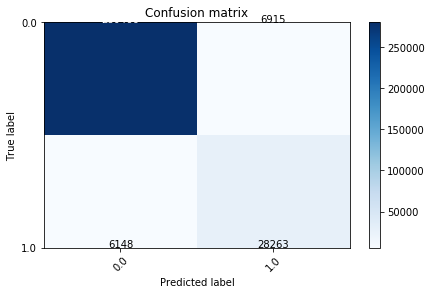

In [19]:
plot_confusion_matrix(cnf_matrix, classes, title='Confusion matrix', cmap=plt.cm.Blues)